# CRAG

In [1]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Gemini model initialized for reranking


E0000 00:00:1759459413.057352   10244 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1759459413.066949   10244 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [6]:
### Build Index with Rate Limiting for Gemini Free API

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
import time
import numpy as np

### from langchain_cohere import CohereEmbeddings

# Set embeddings
embd = embedding_model

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

print("Loading documents...")
# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(f"Loaded {len(docs_list)} documents")

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
print(f"Split into {len(doc_splits)} chunks")

# Custom function to create embeddings with rate limiting for Gemini free API
def create_vectorstore_with_rate_limit(documents, embedding_model, batch_size=3, delay=3.0):
    """
    Create FAISS vectorstore with rate limiting for Gemini free API.
    
    Args:
        documents: List of documents to embed
        embedding_model: The embedding model to use
        batch_size: Number of documents to process per batch (max 5 for free tier)
        delay: Delay in seconds between batches (minimum 2-3 seconds for free tier)
    """
    print(f"Processing {len(documents)} documents in batches of {batch_size} with {delay}s delay...")
    
    # Process first batch to initialize vectorstore
    first_batch = documents[:batch_size]
    print(f"Processing batch 1/{(len(documents) + batch_size - 1) // batch_size}: {len(first_batch)} documents")
    
    vectorstore = FAISS.from_documents(
        documents=first_batch,
        embedding=embedding_model,
    )
    
    # Process remaining documents in batches
    for i in range(batch_size, len(documents), batch_size):
        batch_num = (i // batch_size) + 1
        total_batches = (len(documents) + batch_size - 1) // batch_size
        
        # Wait before processing next batch to respect rate limits
        print(f"Waiting {delay} seconds before next batch...")
        time.sleep(delay)
        
        batch = documents[i:i + batch_size]
        print(f"Processing batch {batch_num}/{total_batches}: {len(batch)} documents")
        
        # Create temporary vectorstore for this batch
        temp_vectorstore = FAISS.from_documents(
            documents=batch,
            embedding=embedding_model,
        )
        
        # Merge with main vectorstore
        vectorstore.merge_from(temp_vectorstore)
    
    print("✓ Vectorstore creation completed!")
    return vectorstore

# Create vectorstore with rate limiting
vectorstore = create_vectorstore_with_rate_limit(
    documents=doc_splits,
    embedding_model=embd,
    batch_size=3,  # Conservative batch size for free tier
    delay=3.0      # 3 second delay between batches
)

retriever = vectorstore.as_retriever()
print("✓ Retriever initialized successfully")

Loading documents...
Loaded 3 documents
Split into 88 chunks
Processing 88 documents in batches of 3 with 3.0s delay...
Processing batch 1/30: 3 documents
Loaded 3 documents
Split into 88 chunks
Processing 88 documents in batches of 3 with 3.0s delay...
Processing batch 1/30: 3 documents
Waiting 3.0 seconds before next batch...
Waiting 3.0 seconds before next batch...
Processing batch 2/30: 3 documents
Processing batch 2/30: 3 documents
Waiting 3.0 seconds before next batch...
Waiting 3.0 seconds before next batch...
Processing batch 3/30: 3 documents
Processing batch 3/30: 3 documents
Waiting 3.0 seconds before next batch...
Waiting 3.0 seconds before next batch...
Processing batch 4/30: 3 documents
Processing batch 4/30: 3 documents
Waiting 3.0 seconds before next batch...
Waiting 3.0 seconds before next batch...
Processing batch 5/30: 3 documents
Processing batch 5/30: 3 documents
Waiting 3.0 seconds before next batch...
Waiting 3.0 seconds before next batch...
Processing batch 6/30

In [8]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function callfrom langchain_openai import ChatOpenAI
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
##chain the prompt with the LLM
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [9]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Agent memory includes short-term and long-term memory. Short-term memory utilizes in-context learning, while long-term memory retains information over extended periods using an external vector store for fast retrieval. There are also different types of memory, such as sensory, explicit, and implicit memory.


In [10]:
### Question Re-writer


# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Here are a few options for improved questions, depending on the specific intent behind "agent memory":\n\n**Option 1 (Focus on AI Agents):**\n\n*   **What are the different types of memory used in AI agents?** (This assumes the user is interested in the technical aspects of how AI agents store and retrieve information.)\n\n**Option 2 (Focus on the concept of memory in agents):**\n\n*   **How does agent memory work?** (This is a more general question about the concept of memory in agents.)\n\n**Option 3 (Focus on the application of agent memory):**\n\n*   **What are the applications of agent memory?** (This assumes the user is interested in the applications of agent memory.)\n\n**Option 4 (Focus on the challenges of agent memory):**\n\n*   **What are the challenges of agent memory?** (This assumes the user is interested in the challenges of agent memory.)\n\n**Option 5 (Focus on the benefits of agent memory):**\n\n*   **What are the benefits of agent memory?** (This assumes the user is

In [11]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [12]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [13]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

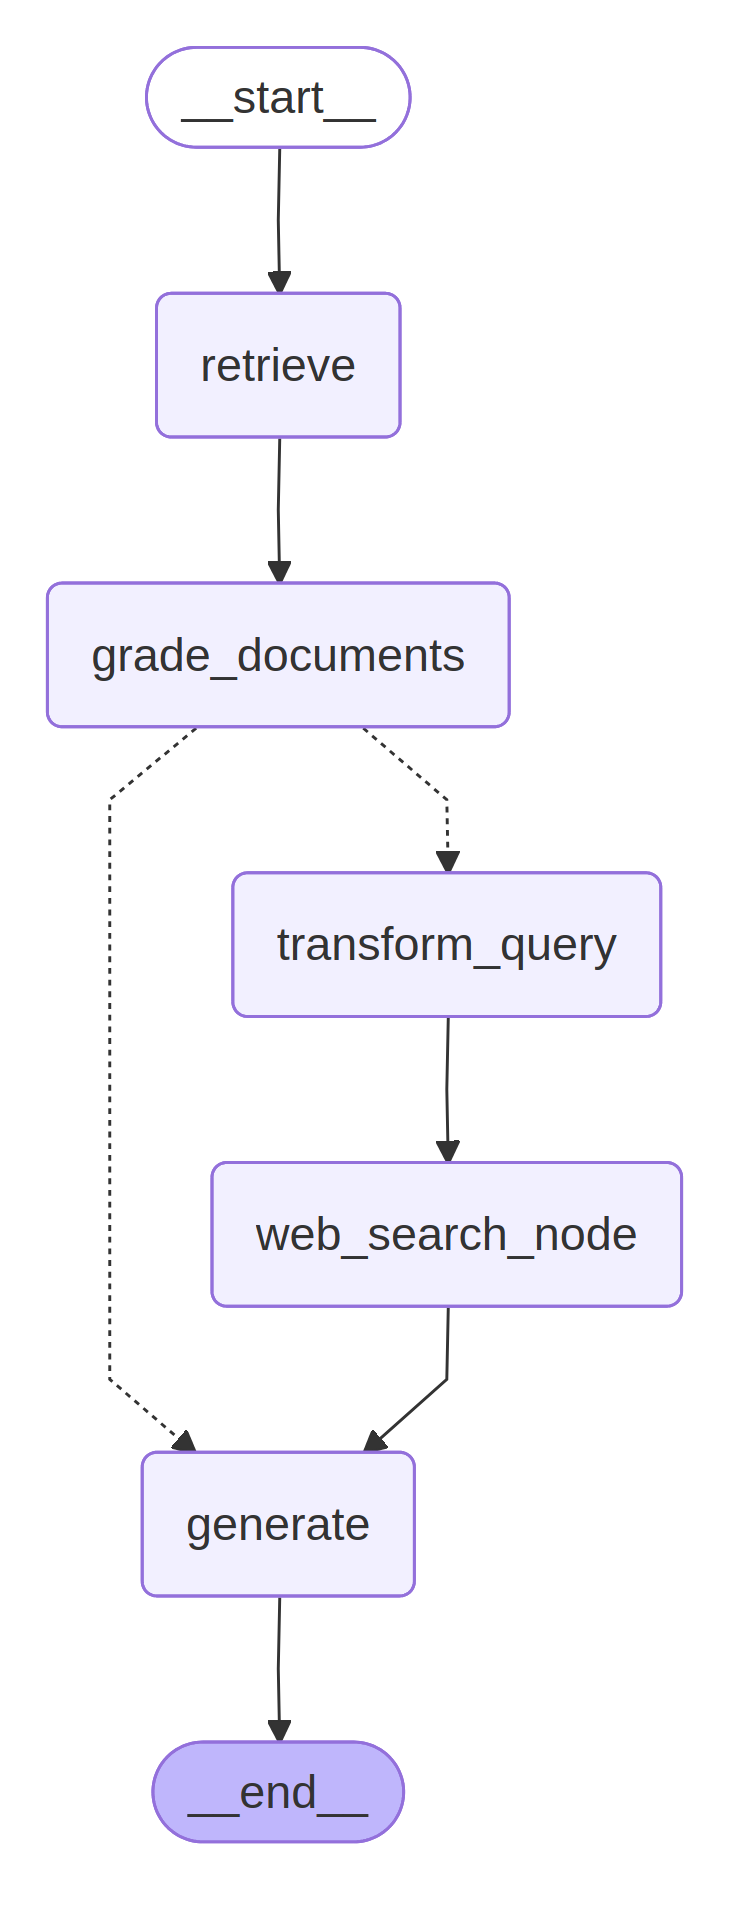

In [14]:
from langgraph.graph import END, StateGraph, START

from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()
# Visualize the workflow graph
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [15]:
app.invoke({"question":"What are the types of agent memory?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---


{'question': 'What are the types of agent memory?',
 'generation': 'Agent memory includes sensory memory, short-term memory, and long-term memory. Sensory memory retains sensory information for a few seconds, while short-term memory stores information for about 20-30 seconds. Long-term memory can store information from a few days to decades and has two subtypes: explicit/declarative and implicit/procedural memory.',
 'web_search': 'No',
 'documents': [Document(id='886bbd31-8ad1-4864-929d-c17f9c19e014', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solve

In [7]:
# Test the retriever
query = "What are the main components of an AI agent?"
docs = retriever.invoke(query)
print(f"Retrieved {len(docs)} documents for query: '{query}'")
print("\nFirst document preview:")
print(docs[0].page_content[:200] + "...")
print(f"Document source: {docs[0].metadata.get('source', 'Unknown')}")

Retrieved 4 documents for query: 'What are the main components of an AI agent?'

First document preview:
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a s...
Document source: https://lilianweng.github.io/posts/2023-06-23-agent/
